#

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

import random

#
# Read in an image file, errors out if we can't find the file
#
def readImage(filename, scale):

    img = cv2.imread(filename,0)
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    img = cv2.resize(img, (w, h))

    if img is None:
        print('Invalid image:' + filename)
        return None
    else:
        print('Image successfully read...')
        return img

def readImageColor(filename, scale):
    img = cv2.imread(filename)
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    img = cv2.resize(img, (w, h))
    if img is None:
        print('Invalid image:' + filename)
        return None
    else:
        print('Image successfully read...')
        return img

In [2]:
# This draws matches and optionally a set of inliers in a different color

# include the drawMatches function
def drawMatches(img1, kp1, img2, kp2, matches, inliers = None):
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1,:] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:cols1+cols2,:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns, y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        inlier = False

        if inliers is not None:
            for i in inliers:
                if i.item(0) == x1 and i.item(1) == y1 and i.item(2) == x2 and i.item(3) == y2:
                    inlier = True

        # Draw a small circle at both co-ordinates
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points, draw inliers if we have them
        if inliers is not None and inlier:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 255, 0), 1)
        elif inliers is not None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 0, 255), 1)

        if inliers is None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)

    return out




In [3]:
#
# Runs sift algorithm to find features
#

def findFeatures(img):
    print("Finding Features...")
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)

    img = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv2.imwrite('sift_keypoints.png', img)

    return keypoints, descriptors


#
# Matches features given a list of keypoints, descriptors, and images
#
def matchFeatures(kp1, kp2, desc1, desc2, img1, img2):
    print("Matching Features...")
    matcher = cv2.BFMatcher(cv2.NORM_L2, True)
    matches = matcher.match(desc1, desc2)
    matchImg = drawMatches(img1,kp1,img2,kp2,matches)
    cv2.imwrite('Matches.png', matchImg)
    return matches


#
# Computers a homography from 4-correspondences
#


In [4]:
def matchFeatures01(kp1, kp2, des1, des2, img1, img2):
    matches = {'queryIndx': [],
               'trainIndx': []
               }
    np.random.seed(2)
    idx2 = np.random.choice(np.arange(0, len(des2)), 7000, )
    idx1 = np.random.choice(np.arange(0, len(des1)), 7000, )
    des2 = des2[idx2]
    for i, des in enumerate(des1[idx1]):
        dists = np.linalg.norm((des - des2), axis=1) ** 2
        sorted_dist = np.sort(dists, axis=0)
        if sorted_dist[0] < 0.75 * sorted_dist[1]:
            matches['queryIndx'].append(idx1[i])
            matches['trainIndx'].append(idx2[np.argsort(dists)][0])
        else:
            continue
    return matches

In [5]:
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h


#
#Calculate the geometric distance between estimated points and original points
#
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)




In [12]:
#
#Runs through ransac algorithm, creating homographies from random correspondences
#
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    random.seed(2)
    for i in range(500):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 10:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        # print ("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers




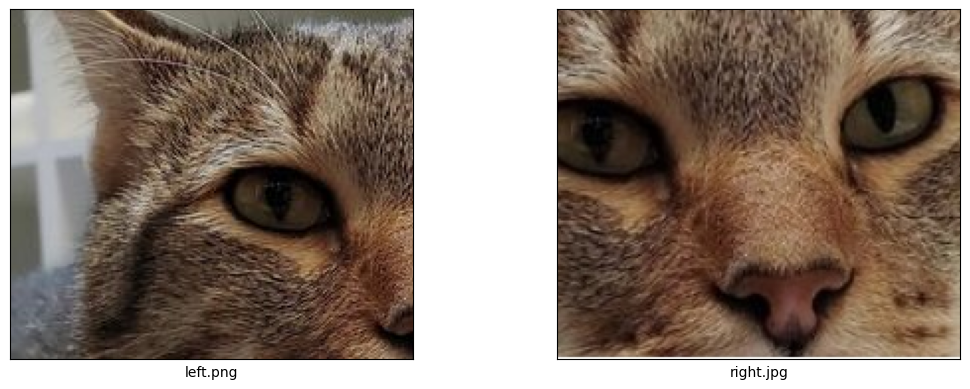

In [13]:
import os
import matplotlib.pyplot as plt
path = 'data'
imgs = os.listdir(path)
images = []
for i, img in enumerate(imgs):
    file_path = os.path.join(path, img)
    images.append(plt.imread(file_path))
plt.figure(figsize=(20,10))
for i in range(len(images)):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.xlabel(imgs[i])
    plt.xticks([])
    plt.yticks([])

Image successfully read...
Image successfully read...
Image successfully read...
Image successfully read...
Finding Features...
Finding Features...
Found keypoints in ./data/left.png: 208
Found keypoints in ./data/right.jpg: 301
Matching Features...


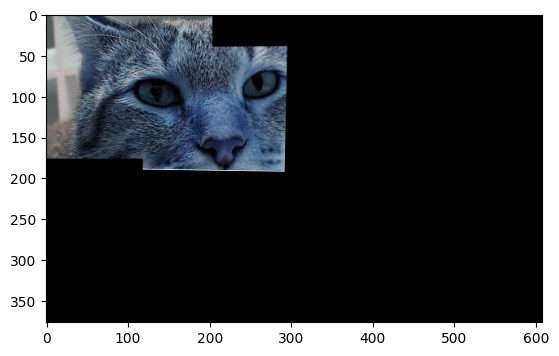

In [16]:
import matplotlib.pyplot as plt

output_image = 'stitched02-hori'
orien = 'horizontal'
scale = 1
img_name = ['./data/left.png', './data/right.jpg']
estimation_thresh = 0.5
if estimation_thresh is None:
    estimation_thresh = 0.50

img1name = str(img_name[0])
img2name = str(img_name[1])

img1 = readImage(img_name[0], scale)
img2 = readImage(img_name[1], scale)

img1_color = readImageColor(img_name[0], scale)
img2_color = readImageColor(img_name[1], scale)

#find features and keypoints
correspondenceList = []
if img1 is not None and img2 is not None:
    kp1, desc1 = findFeatures(img1)
    kp2, desc2 = findFeatures(img2)
    print ("Found keypoints in " + img1name + ": " + str(len(kp1)))
    print ("Found keypoints in " + img2name + ": " + str(len(kp2)))
    keypoints = [kp1,kp2]
    matches = matchFeatures(kp1, kp2, desc1, desc2, img1, img2)
    #matches = matchFeatures01(kp1, kp2, desc1, desc2, img1, img2)
    
    for match in matches:
        (x1, y1) = keypoints[0][match.queryIdx].pt
        (x2, y2) = keypoints[1][match.trainIdx].pt
        correspondenceList.append([x2, y2, x1, y1])

    corrs = np.matrix(correspondenceList)

    #run ransac algorithm
    finalH, inliers = ransac(corrs, estimation_thresh)
    finalH = calculateHomography(inliers)
    
    final_shape = (img1.shape[1] + img2.shape[1] + 500, img2.shape[0] + 500)
    
    
#     finalH[0,2] = final_shape[0] / 2
#     finalH[1,2] = final_shape[1] / 2
    # matchImg = drawMatches(img1,kp1,img2,kp2,matches,inliers)
    # cv2.imwrite('InlierMatches.png', matchImg)


    # #dst = cv2.warpPerspective(src=img2,M=finalH,dsize=((img1.shape[1] + img2.shape[1]), img2.shape[0])) #wraped image
    if orien == 'vertical':
        dst = cv2.warpPerspective(src=img2_color,M=finalH,dsize=((img1.shape[1], (img1.shape[0]+img2.shape[0])))) #wraped image
        #dst[0:img1.shape[0], 0:img1.shape[1]] = cv2.addWeighted(dst[0:img1.shape[0], 0:img1.shape[1]],0.5, img1_color, 0.5,0) #stitched image
        #dst[0:img1.shape[0], 0:img1.shape[1]] = img1_color
        dst[0:img1.shape[0], 0:img1.shape[1]] = ((cv2.bitwise_or(dst[0:img1.shape[0], 0:img1.shape[1]], img1_color)))
        #dst1 = cv2.addWeighted(dst, 0.3, img1_color, 0.7, 0 )
        cv2.imwrite(f'output/{output_image}.jpg',dst)
        plt.imshow(dst)
        plt.show()
    else:
        dst = cv2.warpPerspective(src=img2_color,M=finalH,dsize=((img1.shape[1] + img2.shape[1] + 200), img2.shape[0] + 200)) #wraped image
        dst[0:img2.shape[0], 0:img1.shape[1]] = img1_color #stitched image
        # cv2.addWeighted(dst[0:img2.shape[0], 0:img1.shape[1]], 0.3, img1_color, 0.7, 0 )
        cv2.imwrite(f'output/{output_image}.jpg',dst)
        plt.imshow(dst)
        plt.show()
    # plt.imshow(img1)
    # plt.show()